In [1]:
# import self-written modules
from IndModels.models import PosModel,NGModel,GAACModel
from Ensemble.model import Ensemble

In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import modules
import numpy as np

np.random.seed(4802)

In [4]:
from helper import parseEnzymeFile,modified_split

In [5]:
enzyme_filename = 'Data/Enzyme-Dataset-Modified.csv'

X,y,enz_names = parseEnzymeFile(enzyme_filename)

In [6]:
test_idx,train_idx = modified_split(enz_names)

# Auto-Position-Model

- Bring in Auto Pos
- Align, find best positions 
- Encode those positions using GAA k Mer 
- Predict using SVM

In [7]:
Aligned_Data_File = 'Data/Modified-Enzyme-Alignment.txt'

In [8]:
from AutoPos.model import OhePosModel
from sklearn.feature_selection import mutual_info_classif

In [9]:
def multi_func(iterations):
    autoPosObj = OhePosModel(Aligned_Data_File,mutual_info_classif,None,100)
    return autoPosObj.BestPositions
    
    

In [10]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

In [11]:
best_poss = list(pool.map(multi_func,[i for i in range(100)]))

In [12]:
def func(mylist):
    newlist = [i//10 for i in mylist]
    return set(newlist)

In [13]:
best_poss_parsed = list(map(func,best_poss))

In [14]:
curr_count_dict = {}
for poss in best_poss:
    for pos in poss:
        if pos not in curr_count_dict:
            curr_count_dict[pos] = 1
        else:
            curr_count_dict[pos] += 1

In [15]:
parsed_imp_pos = [k for k,v in curr_count_dict.items() if v>10]

In [16]:
def get_pos_imp(p_imp_list,max_len=533):
    p_imp = []
    for p in sorted(p_imp_list):
        pos_start = p*10
        pos_end = pos_start+10
        p_imp.extend(list(range(pos_start,min(pos_end,max_len-1))))
    return p_imp

In [17]:
# curr_set = None

# for poss in best_poss_parsed:
#     if not curr_set:
#         curr_set = set(poss)
#     else:
#         curr_set = curr_set.union(set(poss))
    

In [18]:
# autoPosObj = OhePosModel(Aligned_Data_File,mutual_info_classif,'Data/new_aligned_best_positions.txt',100)

In [19]:
imp_pos = get_pos_imp(parsed_imp_pos) #
imp_pos = [i for i in range(140,505)]

In [20]:
X_algn,y,enz_names = parseEnzymeFile(Aligned_Data_File)

In [21]:
X_imp = np.array(list(map(list,X_algn)))[:,imp_pos]

In [22]:
X_imp.shape

(116, 365)

In [23]:
autoposModel = GAACModel(enz_names,X_imp,y,train_idx,test_idx,k=7,s=1,random_seed=4308,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9655172413793104-----
-----Testing Accuracy:0.48148148148148145-----


In [24]:
autoposModel2 = NGModel(enz_names,X_imp,y,train_idx,test_idx,k=7,s=1,random_seed=4308,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9770114942528736-----
-----Testing Accuracy:0.48148148148148145-----


In [25]:
yhat1 = autoposModel.SVMobject.ypredtest

In [26]:
# posModel = PosModel('Data/TE_ML_Data_pickle.p',enz_names,X,y,train_idx,test_idx,verboseQ=True,random_seed=7)

# NG only model

In [27]:
ngModel = NGModel(enz_names,X,y,train_idx,test_idx,k=7,s=1,classweight={3:0.55,2:0.2,1:0.25},verboseQ=True,random_seed=4308)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9655172413793104-----
-----Testing Accuracy:0.5185185185185185-----


In [28]:
yhat2 = ngModel.SVMobject.ypredtest

# GAAC and NG model

In [29]:
gaacModel = GAACModel(enz_names,X,y,train_idx,test_idx,k=7,s=1,pca_components=40,probability=True,verboseQ=True,random_seed=4308)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9885057471264368-----
-----Testing Accuracy:0.48148148148148145-----


In [30]:
yhat3 = gaacModel.SVMobject.ypredtest

# Majority Vote Classifier

- Only after autopos

In [31]:
EModel = Ensemble([autoposModel.model,gaacModel.model,ngModel.model],
                  [autoposModel.Xtest,gaacModel.Xtest,ngModel.Xtest],y[test_idx])

In [32]:
yhat4 = EModel.preds

# Predictions

In [33]:
EModel.acc

0.5185185185185185

In [34]:
for e,i,j,k,l,m in zip(enz_names[test_idx],yhat1,yhat2,yhat3,yhat4,y[test_idx]):
    print(e,i,j,k,l,m)

Cuphea_viscosisssima_(CvB2MT13 2 2 2 2 2
Physcomitrella_patens 3 1 1 1 1
Cinnamomum_camphorum 1 3 3 3 2
Sorghum_bicolor_1 1 1 1 1 1
rTE52 3 3 3 3 3
Gossypium_hirsutum 1 1 1 1 1
Cocos_nucifera_(CnFatB1) 1 1 1 1 2
Cuphea_viscosisssima_(CvB2MT28 1 3 3 3 2
Cuphea_viscosisssima_(CvB2MT17) 1 1 1 1 3
Cuphea_viscosisssima_(CvB2MT11 1 1 1 1 2
Cocos_nucifera_(CnFatB2) 1 1 1 1 1
Cuphea_viscosisssima_(CvB2MT38 3 3 3 3 1
Cuphea_viscosisssima_(CvFatB1 3 3 3 3 3
Iris_germanica_2 1 1 1 1 1
Auxenochlorella_protothecoides 1 1 1 1 1
rTE40 3 3 3 3 2
Cuphea_viscosisssima_(CvFatB2 1 1 1 1 2
UcFatB1(T231K) 1 1 1 1 3
Cuphea_viscosisssima_(CvB2MT10 3 3 2 3 3
Cuphea_viscosisssima_(CvB2MT6) 1 1 1 1 3
Iris_germanica_1 1 1 1 1 1
Cuphea_viscosisssima_(CvB2MT23 1 1 1 1 1
rTE44 3 3 3 3 2
Cuphea_aequipetala_(Ca1FatB2) 3 3 3 3 3
rTE15 3 3 3 3 3
Cuphea_viscosisssima_(CvB2MT21 1 3 3 3 2
Elaeis_guineensis 1 1 1 1 2


# Different random seeds

In [35]:
def multiprocess_func(randomseed):
    np.random.seed(randomseed)
    test_idx_i,train_idx_i = modified_split(enz_names)
    
#     posModel_i = PosModel('Data/TE_ML_Data_pickle.p',enz_names,X,y,train_idx_i,test_idx_i)
    autoposModel_i = GAACModel(enz_names,X_imp,y,train_idx_i,test_idx_i,k=7,s=1,random_seed=randomseed)
#     autoposModel_i2 = NGModel(enz_names,X_imp,y,train_idx_i,test_idx_i,k=7,s=1,random_seed=randomseed)
    ngModel_i = NGModel(enz_names,X,y,train_idx_i,test_idx_i,k=7,s=1,classweight={3:0.55,2:0.2,1:0.25},random_seed=randomseed)
    gaacModel_i = GAACModel(enz_names,X,y,train_idx_i,test_idx_i,k=7,s=1,inc_count=False,random_seed=randomseed)
    
    EModel_i = Ensemble([autoposModel_i.model,gaacModel_i.model,ngModel_i.model],
                  [autoposModel_i.Xtest,gaacModel_i.Xtest,ngModel_i.Xtest],y[test_idx_i])
    
    return autoposModel_i.SVMobject.acc_test,ngModel_i.SVMobject.acc_test,gaacModel_i.SVMobject.acc_test,EModel_i.acc,#autoposModel_i2.SVMobject.acc_test
    
    
    
    

In [36]:
import multiprocessing as mp
print(mp.cpu_count())
pool = mp.Pool(mp.cpu_count())

20


In [37]:
%%time
accs = list(pool.map(multiprocess_func,[i for i in range(10000)]))

CPU times: user 237 ms, sys: 54 ms, total: 291 ms
Wall time: 3min 39s


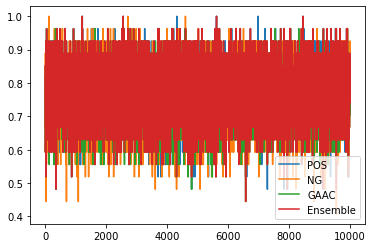

In [38]:
plt.plot(range(len(accs)),accs)
plt.legend(['POS','NG','GAAC','Ensemble'])
# plt.legend(['POS','NG','GAAC','Ensemble','POS2'])

In [39]:
pos_preds = [a[0] for a in accs]
ng_preds = [a[1] for a in accs]
gaac_preds = [a[2] for a in accs]
ensemble_preds = [a[3] for a in accs]
# pos2_preds = [a[4] for a in accs]

In [40]:
min(pos_preds),np.mean(pos_preds),np.std(pos_preds)

(0.48148148148148145, 0.7783629629629629, 0.0747446532030332)

In [41]:
min(ng_preds),np.mean(ng_preds),np.std(ng_preds)

(0.4074074074074074, 0.7677222222222223, 0.07762231155427417)

In [42]:
min(gaac_preds),np.mean(gaac_preds),np.std(gaac_preds)

(0.4444444444444444, 0.7694666666666667, 0.07500932397460712)

In [43]:
min(ensemble_preds),np.mean(ensemble_preds),np.std(ensemble_preds)

(0.4444444444444444, 0.7789333333333334, 0.07383690327554616)

In [44]:
# min(pos2_preds),np.mean(pos2_preds),np.std(pos2_preds)

# How many below a threshold of 0.5

In [45]:
def get_below_thres(preds,thres=0.5):
    return len(np.where(np.array(preds)<thres)[0])

In [46]:
get_below_thres(pos_preds),get_below_thres(ng_preds),get_below_thres(gaac_preds),get_below_thres(ensemble_preds)

(5, 10, 4, 5)

In [47]:
np.argmin(pos_preds)

350

In [ ]:
def save_results(filename,mylist):
    with open(f'Reports/Results/{filename}','w') as f:
        for line in mylist:
            f.write(str(line))
            f.write('\n')
    return 

def save_figure(figurename,mylist):
    plt.figure()
    values = plt.hist(mylist,bins=5);
    b=values[1]
    plt.xlabel('Accuracy bin');
    plt.ylabel('Count');
    plt.xticks(b)
    plt.title(f'{figurename} Test Accuracy Histogram');
    plt.savefig(f"Reports/Results/{'-'.join(figurename.split(' '))}.png");
    return

In [30]:
# save_results('Positional-Model.txt',pos_preds),save_results('k-mer-Model.txt',ng_preds),save_results('GAA-kmer-Model.txt',gaac_preds),save_results('Ensemble-Model.txt',ensemble_preds)

In [31]:
# save_figure('Positional Feature Model',pos_preds),save_figure('kmer Motif Model',ng_preds),save_figure('GAA Motif Model',gaac_preds),save_figure('Ensemble Model',ensemble_preds)